In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import SGD
from numpy.random import seed
from tensorflow.random import set_seed

import matplotlib.pyplot as plt

In [ ]:
seed(0)
set_seed(0)

In [ ]:
data = pd.read_csv('/content/stroke_dataset.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
data.drop(['id'], axis = 1, inplace = True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Preprocessing

In [ ]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
data.bmi.replace(to_replace=np.nan, value=data.bmi.mean(), inplace=True)

In [ ]:
x = data.iloc[:, :-1]
y = data.iloc[:,-1]

In [ ]:
ct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(), [0,5,9])], remainder= 'passthrough')
x = np.array(ct.fit_transform(x))

In [ ]:
le = LabelEncoder()
x[:, 15] = le.fit_transform(x[:, 15])
x[:, 16] = le.fit_transform(x[:, 16])

In [ ]:
x

array([[0.0, 1.0, 0.0, ..., 1, 228.69, 36.6],
       [1.0, 0.0, 0.0, ..., 0, 202.21, 28.893236911794666],
       [0.0, 1.0, 0.0, ..., 0, 105.92, 32.5],
       ...,
       [1.0, 0.0, 0.0, ..., 0, 82.99, 30.6],
       [0.0, 1.0, 0.0, ..., 0, 166.29, 25.6],
       [1.0, 0.0, 0.0, ..., 1, 85.28, 26.2]], dtype=object)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
scaler = StandardScaler()

scaler.fit(x_train)

StandardScaler()

In [ ]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled.shape

(4088, 19)

In [ ]:
x_test_scaled.shape

(1022, 19)

#SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=None)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 195
Before OverSampling, counts of label '0': 3893 

After OverSampling, the shape of train_X: (7786, 19)
After OverSampling, the shape of train_y: (7786,) 

After OverSampling, counts of label '1': 3893
After OverSampling, counts of label '0': 3893


# Device data split

In [ ]:
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train_res, y_train_res, test_size = 0.33, random_state = 0)
x_train1, x_train3, y_train1, y_train3 = train_test_split(x_train1, y_train1, test_size = 0.5, random_state = 0)

In [ ]:
x_train1.shape, y_train1.shape, x_train2.shape, y_train2.shape, x_train3.shape, y_train3.shape

((2608, 19), (2608,), (2570, 19), (2570,), (2608, 19), (2608,))

#Models

In [ ]:
def build_model():
  input = Input(shape = x_train_scaled.shape[-1])
  dense_1 = Dense(units = 8, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(input)
  dense_2 = Dense(units = 8, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense_1)
  classifier = Dense(units = 1, activation = 'sigmoid')(dense_2)

  model = Model(input, classifier)

  return model

In [ ]:
clear_session()
model1 = build_model()
model2 = build_model()
model3 = build_model()

In [ ]:
sgd = SGD()

In [ ]:
model1.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = 'accuracy')
model2.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = 'accuracy')
model3.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = 'accuracy')

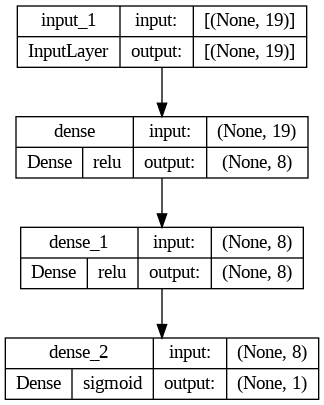

In [ ]:
plot_model(model1,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,)

In [ ]:
history1 = model1.fit(x_train1, y_train1, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = True, verbose = 1)

Epoch 1/50
66/66 [==============================] - 1s 6ms/step - loss: 0.3777 - accuracy: 0.8495 - val_loss: 0.3970 - val_accuracy: 0.8410
Epoch 2/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8543 - val_loss: 0.3927 - val_accuracy: 0.8563
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8519 - val_loss: 0.3948 - val_accuracy: 0.8314
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3766 - accuracy: 0.8514 - val_loss: 0.4753 - val_accuracy: 0.7874
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3793 - accuracy: 0.8567 - val_loss: 0.3903 - val_accuracy: 0.8467
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3774 - accuracy: 0.8523 - val_loss: 0.4028 - val_accuracy: 0.8448
Epoch 7/50
66/66 [==============================] - 0s 6ms/step - loss: 0.3761 - accuracy: 0.8591 - val_loss: 0.3995 - val_accuracy: 0.8467
Epoch 8/50
66/66 [==

In [ ]:
# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('model1 accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
model2.fit(x_train2, y_train2, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = True, verbose = 1)

Epoch 1/50
65/65 [==============================] - 1s 9ms/step - loss: 0.3749 - accuracy: 0.8497 - val_loss: 0.4176 - val_accuracy: 0.8210
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3721 - accuracy: 0.8555 - val_loss: 0.4360 - val_accuracy: 0.8054
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3733 - accuracy: 0.8517 - val_loss: 0.4258 - val_accuracy: 0.8152
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3728 - accuracy: 0.8551 - val_loss: 0.4240 - val_accuracy: 0.8152
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3740 - accuracy: 0.8512 - val_loss: 0.4127 - val_accuracy: 0.8327
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8575 - val_loss: 0.4218 - val_accuracy: 0.8268
Epoch 7/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3727 - accuracy: 0.8560 - val_loss: 0.4166 - val_accuracy: 0.8307
Epoch 8/50
65/65 [==

In [ ]:
model3.fit(x_train3, y_train3, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = True, verbose = 1)

Epoch 1/50
66/66 [==============================] - 1s 6ms/step - loss: 0.3559 - accuracy: 0.8619 - val_loss: 0.4024 - val_accuracy: 0.8467
Epoch 2/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3553 - accuracy: 0.8667 - val_loss: 0.4128 - val_accuracy: 0.8333
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3549 - accuracy: 0.8696 - val_loss: 0.4211 - val_accuracy: 0.8487
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3556 - accuracy: 0.8629 - val_loss: 0.4273 - val_accuracy: 0.8276
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3567 - accuracy: 0.8600 - val_loss: 0.4136 - val_accuracy: 0.8410
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3550 - accuracy: 0.8610 - val_loss: 0.4048 - val_accuracy: 0.8467
Epoch 7/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3543 - accuracy: 0.8648 - val_loss: 0.3999 - val_accuracy: 0.8429
Epoch 8/50
66/66 [==

In [ ]:
local_loss_acc =[model1.evaluate(x_test_scaled, y_test), model2.evaluate(x_test_scaled, y_test), model3.evaluate(x_test_scaled, y_test)]
print(local_loss_acc)
print('SGD FROM NOW ON')

32/32 [==============================] - 0s 4ms/step - loss: 0.5902 - accuracy: 0.7436
[[0.44108617305755615, 0.8003913760185242], [0.6005954742431641, 0.7221134901046753], [0.5902456641197205, 0.7436399459838867]]
SGD FROM NOW ON


In [ ]:
p1_local = np.round(model1.predict(x_test_scaled))
p2_local = np.round(model2.predict(x_test_scaled))
p3_local = np.round(model3.predict(x_test_scaled))


32/32 [==============================] - 0s 1ms/step


In [ ]:
local_cm = [confusion_matrix(y_test,p1_local),confusion_matrix(y_test,p2_local),confusion_matrix(y_test,p3_local)]
local_cr = [classification_report(y_test,p1_local),classification_report(y_test,p2_local),classification_report(y_test,p3_local)]



In [ ]:
print(local_cm[0])
print(local_cm[1])
print(local_cm[2])



[[791 177]
 [ 27  27]]
[[698 270]
 [ 14  40]]
[[726 242]
 [ 20  34]]


In [ ]:
print(local_cr[0])

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       968
           1       0.13      0.50      0.21        54

    accuracy                           0.80      1022
   macro avg       0.55      0.66      0.55      1022
weighted avg       0.92      0.80      0.85      1022



In [ ]:
print(local_cr[1])


              precision    recall  f1-score   support

           0       0.98      0.72      0.83       968
           1       0.13      0.74      0.22        54

    accuracy                           0.72      1022
   macro avg       0.55      0.73      0.53      1022
weighted avg       0.94      0.72      0.80      1022



In [ ]:
print(local_cr[2])


              precision    recall  f1-score   support

           0       0.97      0.75      0.85       968
           1       0.12      0.63      0.21        54

    accuracy                           0.74      1022
   macro avg       0.55      0.69      0.53      1022
weighted avg       0.93      0.74      0.81      1022



#Functions

In [ ]:
def extract_opt_weights(model):
  symbolic_weights = getattr(model.optimizer, 'weights')
  opt_weights = keras.backend.batch_get_value(symbolic_weights)

  return opt_weights

In [ ]:
def average_opt_weights(weight1, weight2, weight3):
  new_weights = []
  new_weights.append(weight1[0])
  i = 1
  for w1,w2,w3 in zip(weight1[1:], weight2[1:], weight3[1:]):
    sub_weights = np.empty(shape = (w1.shape[0], 0))
    sub_weights = np.append(sub_weights, (w1[0] + w2[0] + w3[0]) / 3)
    for x,y,z in zip(w1[1:],w2[1:],w3[1:]):
      sub_weights = np.vstack((sub_weights, (x + y + z) / 3))
    if i%2 == 0:
      sub_weights = np.reshape(sub_weights, newshape = (sub_weights.shape[0], ))
    i += 1
    new_weights.append(sub_weights)
  return new_weights

In [ ]:
def new_opt_weights_model(weight_values, model):
  model.optimizer.set_weights(weight_values)
  return model

#Iterative

In [ ]:
global_loss_acc = []
global_cm = []
global_cr = []

In [ ]:
def run_process(model1, model2, model3, x_train1, y_train1, x_train2, y_train2, x_train3, y_train3):
  weight1 = extract_opt_weights(model1)
  weight2 = extract_opt_weights(model2)
  weight3 = extract_opt_weights(model3)
  print('Weights extracted succesfully')

  new_weights = average_opt_weights(weight1, weight2, weight3)
  print('Weights averaged successfully')

  model1 = new_opt_weights_model(new_weights, model1)
  model2 = new_opt_weights_model(new_weights, model2)
  model3 = new_opt_weights_model(new_weights, model3)
  print('New weights assigned successfully')

  print('Training Model 1')
  history1 = model1.fit(x_train1, y_train1, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = False, verbose = 1)
  # print('Model 1 Accuracy')
  # plt.plot(history1.history['accuracy'])
  # plt.plot(history1.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
  # # summarize history for loss
  # print('Model 1 Loss')
  # plt.plot(history1.history['loss'])
  # plt.plot(history1.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()

  print('Training Model 2')
  history2 = model2.fit(x_train2, y_train2, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = False, verbose = 1)
  # print('Model 2 Accuracy')
  # plt.plot(history2.history['accuracy'])
  # plt.plot(history2.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
  # summarize history for loss
  # print('Model 2 Loss')
  # plt.plot(history2.history['loss'])
  # plt.plot(history2.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()

  print('Training Model 3')
  history3 = model3.fit(x_train3, y_train3, epochs = 50, validation_split = 0.2, workers = -1, use_multiprocessing = False, verbose = 1)
  # print('Model 3 Accuracy')
  # plt.plot(history3.history['accuracy'])
  # plt.plot(history3.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()

  # summarize history for loss
  # print('Model 3 Loss')
  # plt.plot(history3.history['loss'])
  # plt.plot(history3.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()

  global_loss_acc.append(model1.evaluate(x_test_scaled, y_test))
  global_loss_acc.append(model2.evaluate(x_test_scaled, y_test))
  global_loss_acc.append(model3.evaluate(x_test_scaled, y_test))

  return model1, model2, model3

In [ ]:
for i in range(0, 10):
  print('\nIteration:', i+1)
  model1, model2, model3 = run_process(model1, model2, model3, x_train1, y_train1, x_train2, y_train2, x_train3, y_train3)


Iteration: 1
Weights extracted succesfully
Weights averaged successfully
New weights assigned successfully
Training Model 1
Epoch 1/50
66/66 [==============================] - 0s 6ms/step - loss: 0.3761 - accuracy: 0.8495 - val_loss: 0.3934 - val_accuracy: 0.8525
Epoch 2/50
66/66 [==============================] - 0s 5ms/step - loss: 0.3747 - accuracy: 0.8528 - val_loss: 0.3921 - val_accuracy: 0.8602
Epoch 3/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3753 - accuracy: 0.8567 - val_loss: 0.3938 - val_accuracy: 0.8410
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3738 - accuracy: 0.8504 - val_loss: 0.4701 - val_accuracy: 0.7893
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3769 - accuracy: 0.8533 - val_loss: 0.3872 - val_accuracy: 0.8448
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8562 - val_loss: 0.3978 - val_accuracy: 0.8487
Epoch 7/50
66/66 [=================

In [ ]:
model1.evaluate(x_test_scaled, y_test), model2.evaluate(x_test_scaled, y_test), model3.evaluate(x_test_scaled, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.7446


([0.4532375633716583, 0.7847357988357544],
 [0.5999822020530701, 0.7358121275901794],
 [0.6102432012557983, 0.7446184158325195])

In [ ]:
np.save('global_loss_acc_sgd.npy',global_loss_acc)

In [ ]:
p1 = np.round(model1.predict(x_test_scaled))
p2 = np.round(model2.predict(x_test_scaled))
p3 = np.round(model3.predict(x_test_scaled))

32/32 [==============================] - 0s 1ms/step


In [ ]:
global_cm = [confusion_matrix(y_test,p1),confusion_matrix(y_test,p2),confusion_matrix(y_test,p3)]
global_cr = [classification_report(y_test,p1),classification_report(y_test,p2),classification_report(y_test,p3)]

In [ ]:
print(global_cr[0])

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       968
           1       0.12      0.48      0.19        54

    accuracy                           0.78      1022
   macro avg       0.54      0.64      0.53      1022
weighted avg       0.92      0.78      0.84      1022



In [ ]:
print(global_cr[1])


              precision    recall  f1-score   support

           0       0.97      0.74      0.84       968
           1       0.11      0.57      0.19        54

    accuracy                           0.74      1022
   macro avg       0.54      0.66      0.51      1022
weighted avg       0.92      0.74      0.81      1022



In [ ]:
print(global_cr[2])


              precision    recall  f1-score   support

           0       0.97      0.75      0.85       968
           1       0.12      0.57      0.19        54

    accuracy                           0.74      1022
   macro avg       0.54      0.66      0.52      1022
weighted avg       0.92      0.74      0.81      1022



In [ ]:
print(global_cm[0])
print(global_cm[1])
print(global_cm[2])



[[776 192]
 [ 28  26]]
[[721 247]
 [ 23  31]]
[[730 238]
 [ 23  31]]
